<a href="https://colab.research.google.com/github/Bduz/intro_ml/blob/main/intro_rl/dqn/Deep_Q_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's [LunarLander-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) environment.

### 1. Import the Necessary Packages

In [1]:
!git clone https://github.com/Bduz/intro_ml.git

Cloning into 'intro_ml'...
remote: Enumerating objects: 557, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 557 (delta 132), reused 131 (delta 56), pack-reused 290
Receiving objects: 100% (557/557), 52.54 MiB | 10.74 MiB/s, done.
Resolving deltas: 100% (278/278), done.


In [2]:
import sys
sys.path.insert(0, '/content/intro_ml/intro_rl/dqn/')

In [16]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
!pip install swig
!pip install gymnasium[box2d]
import gymnasium as gym

In [17]:
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

<Surface(640x480x32 SW)>

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [23]:
env = gym.make('LunarLander-v2')
env_seed = 0
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


Please refer to the instructions in `Deep_Q_Network.ipynb` if you would like to write your own DQN agent.  Otherwise, run the code cell below to load the solution files.

In [24]:
from dqn_agent import Agent

agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=1)

# watch an untrained agent
state, info = env.reset(seed=env_seed)
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, terminated, truncated, info= env.step(action)
    if terminated or truncated:
        break

env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 100	Average Score: -122.49
Episode 200	Average Score: -125.38
Episode 300	Average Score: -70.29
Episode 400	Average Score: 16.15
Episode 500	Average Score: 29.66
Episode 600	Average Score: 98.79
Episode 700	Average Score: 189.81
Episode 718	Average Score: 200.37
Environment solved in 618 episodes!	Average Score: 200.37


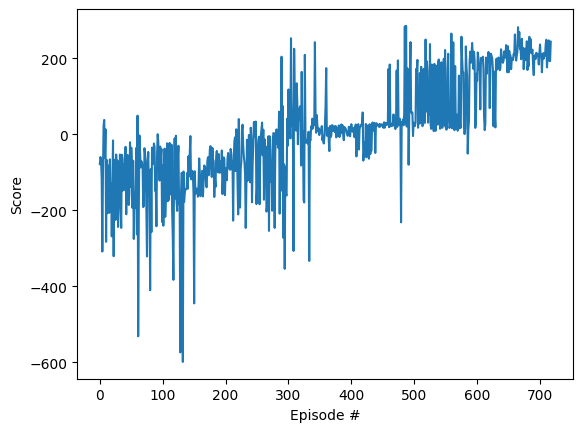

In [25]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    env = gym.make('LunarLander-v2')
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, info = env.reset(seed=env_seed)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if terminated or truncated:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [27]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state, info = env.reset()
    for j in range(200):
        action = agent.act(state)
        env.render()
        state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 5. Animate it with Video

In [31]:
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import io
import base64

def show_video(env_name):
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = '{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode="rgb_array")
    vid = video_recorder.VideoRecorder(env, path="{}.mp4".format(env_name))
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state,info = env.reset()
    done = False
    while not done:
        frame = env.render()
        vid.capture_frame()
        action = agent.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    env.close()

In [32]:
agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2')

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [33]:
show_video('LunarLander-v2')

### 6. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN. See [OpenAI DQN blog](https://openai.com/research/openai-baselines-dqn) for more info.
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  